In [1]:
import json

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
import numpy as np

In [2]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
#         for doc_index in top_doc_indices:
#             print documents[doc_index]

## Generate topics

In [3]:
file = 'processed_reviews.json'
with open(file) as f:
    head = [json.loads(next(f)) for x in range(100000)]
    
documents = []
for i in head:
    documents.extend(i['text'].split('.'))

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 5

# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

no_top_words = 10
no_top_documents = 10
display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words, no_top_documents)

Topic 0:
great service friendly staff atmosphere customer experience excellent price nice
Topic 1:
place love recommend like really try amaze highly awesome nice
Topic 2:
good really service pretty price taste pizza overall fry portion
Topic 3:
food delicious amaze excellent price fresh quality best ok awesome
Topic 4:
time come order definitely try wait just like eat make


## Topic distribution

In [4]:
import matplotlib.pyplot as plt

topics = {}

test_documents = documents[:10000]

for document in test_documents:
    for sentence in document.split('.'):
        sentence = sentence.strip()
        if sentence:
            sentence_topics = nmf_model.transform(tfidf_vectorizer.transform([document]))
            # get top topic
            top_topic = 0
            top_topic_val = float('-inf')
            for topic, topic_val in enumerate(sentence_topics[0]):
                if (topic_val > top_topic_val) and (topic != 4):
                        top_topic_val = topic_val
                        top_topic = topic
#            top_topic = sentence_topics[0].argmax(axis=0)
            if top_topic in topics:
                topics[top_topic].append(sentence)
            else:
                topics[top_topic] = [sentence]

{2: 1862, 3: 2142, 0: 3332, 1: 2634}
{2: 18.62, 3: 21.42, 0: 33.32, 1: 26.340000000000003}


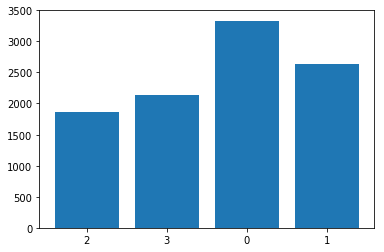

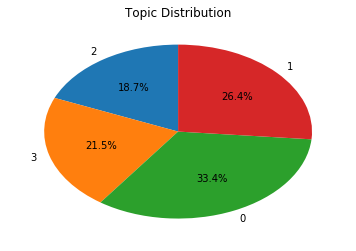

In [5]:
# topics and sentences counts
topic_counts = {topic: len(sentences) for topic, sentences in topics.items()}
print (topic_counts)

# topics and sentences perecentages
topic_percentages = {topic: (len(sentences) * 1.0 / len(test_documents) * 100) for topic, sentences in topics.items()}
print (topic_percentages)

# plot topics and sentence counts
plt.bar(range(len(topic_counts)), topic_counts.values(), align='center')
plt.xticks(range(len(topic_counts)), topic_counts.keys())
plt.show()

# plot topics and percentages
# Data to plot
labels = topic_percentages.keys()
sizes = list(topic_percentages.values())
plt.pie(sizes, labels=labels, startangle=90, autopct='%.1f%%')
plt.title('Topic Distribution')
plt.show()

## Dump and predictions tests

In [6]:
from sklearn.externals import joblib
joblib.dump(nmf_model, 'nmf_model.joblib') 

['nmf_model.joblib']

In [7]:
clf = joblib.load('nmf_model.joblib') 

In [8]:
clf.transform(tfidf_vectorizer.transform(['the staff is very friendly great service so attentive']))

array([[ 0.02246671,  0.        ,  0.0002564 ,  0.        ,  0.00088919]])

In [9]:
nmf_model.transform(tfidf_vectorizer.transform(['the staff is very friendly great service so attentive']))

array([[ 0.02246671,  0.        ,  0.0002564 ,  0.        ,  0.00088919]])

In [10]:
nmf_model.transform(tfidf_vectorizer.transform(['i love the chicken pizza']))

array([[ 0.        ,  0.00995166,  0.00061466,  0.        ,  0.00162527]])

In [11]:
nmf_model.transform(tfidf_vectorizer.transform(['i like the chicken pizza']))

array([[ 0.        ,  0.0007768 ,  0.00074969,  0.        ,  0.00467051]])

In [12]:
nmf_model.transform(tfidf_vectorizer.transform(['they have fresh sushi that you can have with any drink']))

array([[ 0.00022711,  0.00022009,  0.00034331,  0.00123804,  0.00248664]])

In [15]:
nmf_model.transform(tfidf_vectorizer.transform(['The servings and portion are huge and true value for money.']))

array([[ 0.00011222,  0.        ,  0.00039899,  0.00032327,  0.00060412]])